In [1]:
# 精确积分法求解
# 引入所需要的库
# 作者：Jiajun Du
import math
import numpy as np
import matplotlib.pyplot as plt
# import time
# from tqdm import tqdm,trange
#plt.style.use("ggplot")
plt.rcParams['font.sans-serif'] = ['Microsoft Yahei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# title：绘图标题；ta：地震动时序，a：地震动加速度幅值，t:周期时序，u:位移最大值序列，v，amax分别为速度和加速度最大值序列
from numba import jit

# 用Newmark方法求解地震动下结构的反应，omg：结构自振圆频率，zeta：结构阻尼比
# ag：地震加速度值，dt：地震步长
@jit(nopython=True)
def solve_sdof_eqwave_nmk(omg,zeta,ag,dt):
    omg2 = omg * omg
    #Newmark方法参数，gama和beta，本取值代表了采用的是线加速度法,如果把beta换成0.25就是平均加速度法
    gama = 0.5
    beta = 1 / 6
    
    c = 2*zeta*omg # 阻尼，除以质量m
    keq = omg2 + gama/(beta*dt)*c + 1/(beta*dt*dt)  #等效刚度
    
    n = len(ag)
    u = np.zeros(n)
    v = np.zeros(n)
    a = np.zeros(n)
    u[0] = 0.0 #初始位移设为0
    v[0] = 0.0 #初始速度设为0
    a[0] = -ag[0]-c*v[0]-omg2*u[0] # 利用运动方程给出时间间隔下的初始加速度
    
    for i in range(n-1):
        peq = (-ag[i+1] + (1/beta/dt/dt+gama/beta/dt*c)*u[i] + (1/beta/dt+(gama/beta-1)*c)*v[i]
               +((1/2/beta-1)+dt*(gama/2/beta-1)*c)*a[i])
        u[i+1] = peq/keq
        v[i+1] = gama/beta/dt*(u[i+1]-u[i])+(1-gama/beta)*v[i]+dt*(1-gama/2/beta)*a[i]
        a[i+1] = -ag[i+1]-c*v[i+1]-omg2*u[i+1]
        
    umax = max(np.abs(u))
    vmax = max(np.abs(v))
    amax = omg2*umax
    return umax,vmax,amax


@jit(nopython=True)
def solve_nigam_jennings(omg, zeta, ag, dnt):
    w = omg
    h = zeta
    dt = dnt
    c = 2*h*w # 阻尼，除以质量m
    wd = math.sqrt(1-h*h) * w
    w2 = w*w
    w3 = w*w*w
    wddt = wd*dt
    swddt = math.sin(wddt)
    cwddt = math.cos(wddt)
    ehwt = math.exp(-h*w*dt)
    hc = h/(math.sqrt(1-h*h))
    a11 = ehwt*(hc*swddt+cwddt)
    a12 = ehwt/wd*swddt
    a21 = -w/(math.sqrt(1-h*h))*ehwt*swddt
    a22 = ehwt*(cwddt-hc*swddt)
    
    hc2 = (2*h*h-1)/(w*w*dt)
    hw3dt = 2*h/w/w/w/dt
    b11 = ehwt*((hc2+h/w)*swddt/wd+(hw3dt+1/w/w)*cwddt)-hw3dt
    b12 = -ehwt*(hc2*swddt/wd+hw3dt*cwddt)-1/w/w+hw3dt
    b21 = ehwt*((hc2+h/w)*(cwddt-hc*swddt)-(hw3dt+1/w/w)*(wd*swddt+h*w*cwddt))+1/w/w/dt
    b22 = -ehwt*(hc2*(cwddt-hc*swddt)-hw3dt*(wd*swddt+h*w*cwddt))-1/w/w/dt
    n = len(ag)
    u = np.zeros(n)
    v = np.zeros(n)
    a = np.zeros(n)
    u[0] = 0.0 #初始位移设为0
    v[0] = 0.0 #初始速度设为0
    a[0] = -ag[0]-c*v[0]-w2*u[0] # 利用运动方程给出时间间隔下的初始加速度
    for i in range(n-1):
        u[i+1] = a11*u[i] + a12*v[i] + b11*ag[i] + b12*ag[i+1]
        v[i+1] = a21*u[i] + a22*v[i] + b21*ag[i] + b22*ag[i+1]
        
    umax = max(np.abs(u))
    vmax = max(np.abs(v))
    amax = w2*umax
    return umax,vmax,amax

## 伪加速度谱

In [3]:
# Sa 伪加速度
import pandas as pd
from StochasticGroundMotionModeling import StochasticGroundMotionModeling
if __name__ == '__main__':
    Sa_set = np.zeros((5000, 120))
    Sd_set = np.zeros((5000, 120))
    index = 0
    ACC_set = np.loadtxt(r'C:\Users\12734\OneDrive\重要文件\2_SensitivityAnalysis\Main_3s_230927_omf\地震动\ACC_1_93.txt')
    for i in range(120):
        acc0 = ACC_set[i, :]
        dt = 0.01
        acc0 = acc0
        n = len(acc0)
        t0 = np.linspace(0.0,dt*(n-1),n)
        ag = acc0
        dnt=0.01
        zetas = [0.05]
        num = 5000
        row = len(zetas)
        umax = np.zeros((row,num))
        vmax = np.zeros((row,num))
        amax = np.zeros((row,num))
        T = np.linspace(0.01,6.00,num)  #支持更高精度
        j=0
        for zeta in zetas: 
            i = 0
            for T1 in T:
                omg = 2.0*np.pi/T1
                umax[j][i], vmax[j][i], amax[j][i] = solve_nigam_jennings(omg, zeta, ag, dnt) #此处的dnt应该是迭代步长
                i = i+1
            j += 1 
        Sa_set[:, index] = amax[0, :]
        Sd_set[:, index] = umax[0, :]
        index += 1
    np.savetxt('acc_1_93.txt', Sa_set)

In [9]:
# Sa 伪加速度
import pandas as pd
from StochasticGroundMotionModeling import StochasticGroundMotionModeling
if __name__ == '__main__':
    
    # Stochastic Model
    # plt.figure()
    Sa_set = np.zeros((5000, 100))
    Sd_set = np.zeros((5000, 100))
    index = 0
    for i in range(100):
        acc0, dt = StochasticGroundMotionModeling(6.69, 20.3, 1223, 0)
        
        # acc0 = np.array(acc_0)
        # acc0 = acc0/100
        acc0 = acc0
        # dt = 0.02
        # dt = 0.01
        n = len(acc0)
        t0 = np.linspace(0.0,dt*(n-1),n)
        ag = acc0
        dnt=0.01
        # zetas = [0.01,0.02,0.03,0.04,0.05,0.1]
        zetas = [0.05]
        
        num = 5000
        row = len(zetas)
        umax = np.zeros((row,num))
        vmax = np.zeros((row,num))
        amax = np.zeros((row,num))
        T = np.linspace(0.01,6.00,num)  #支持更高精度
        j=0
        for zeta in zetas: 
            i = 0
            for T1 in T:
                omg = 2.0*np.pi/T1
                umax[j][i], vmax[j][i], amax[j][i] = solve_nigam_jennings(omg, zeta, ag, dnt) #此处的dnt应该是迭代步长
                i = i+1
            j += 1 
        # for js in range(j):
        #     plt.loglog(T,amax[js,:],label = r"damp=%s" % zetas[js], color = 'gray')
        Sa_set[:, index] = amax[0, :]
        Sd_set[:, index] = umax[0, :]
        index += 1
    np.savetxt('dis_set.txt', Sd_set)
    # plt.xlabel(r"周期（s）",fontsize=10)
    # plt.ylabel(r"Sa（g）",fontsize=10)
    # plt.grid(True)
    # plt.xlim(0.1,5)
    # plt.ylim(1e-3, 10)

In [13]:
Sd_set = Sd_set*9.8
np.savetxt('dis_set.txt', Sd_set)

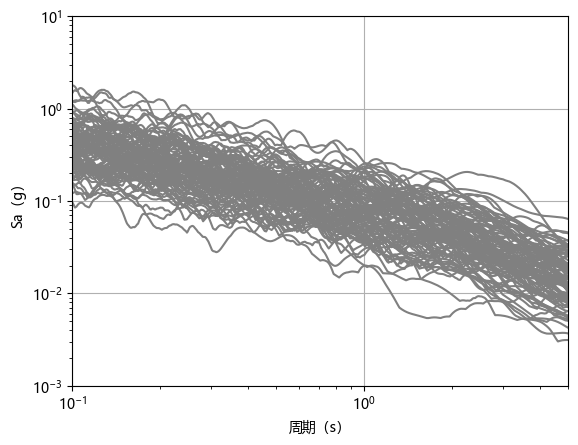

In [7]:
# Sa 伪加速度
import pandas as pd
from StochasticGroundMotionModeling import StochasticGroundMotionModeling
if __name__ == '__main__':
    
    # Stochastic Model
    # plt.figure()
    Sa_set = np.zeros((5000, 100))
    Sd_set = np.zeros((5000, 100))
    index = 0
    for i in range(100):
        acc0, dt = StochasticGroundMotionModeling(6.69, 20.3, 1223, 0)
        
        # acc0 = np.array(acc_0)
        # acc0 = acc0/100
        acc0 = acc0
        # dt = 0.02
        # dt = 0.01
        n = len(acc0)
        t0 = np.linspace(0.0,dt*(n-1),n)
        ag = acc0
        dnt=0.01
        # zetas = [0.01,0.02,0.03,0.04,0.05,0.1]
        zetas = [0.05]
        
        num = 5000
        row = len(zetas)
        umax = np.zeros((row,num))
        vmax = np.zeros((row,num))
        amax = np.zeros((row,num))
        T = np.linspace(0.01,6.00,num)  #支持更高精度
        j=0
        for zeta in zetas: 
            i = 0
            for T1 in T:
                omg = 2.0*np.pi/T1
                umax[j][i], vmax[j][i], amax[j][i] = solve_nigam_jennings(omg, zeta, ag, dnt) #此处的dnt应该是迭代步长
                i = i+1
            j += 1 
        for js in range(j):
            plt.loglog(T,amax[js,:],label = r"damp=%s" % zetas[js], color = 'gray')
    plt.xlabel(r"周期（s）",fontsize=10)
    plt.ylabel(r"Sa（g）",fontsize=10)
    plt.grid(True)
    plt.xlim(0.1,5)
    plt.ylim(1e-3, 10)

In [8]:
T = np.linspace(0.01,6.00, 5000)
np.savetxt('T.txt', T)

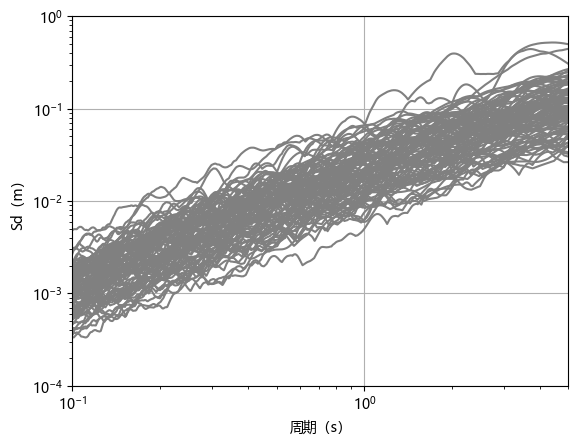

In [12]:
# Sd
import pandas as pd
from StochasticGroundMotionModeling import StochasticGroundMotionModeling
if __name__ == '__main__':
    
    plt.figure()
    for i in range(100):
        acc0, dt = StochasticGroundMotionModeling(6.69, 20.3, 1223, 0)
        
        # acc0 = np.array(acc_0)
        # acc0 = acc0/100
        acc0 = acc0 * 9.8
        # dt = 0.02
        # dt = 0.01
        n = len(acc0)
        t0 = np.linspace(0.0,dt*(n-1),n)
        ag = acc0
        dnt=0.01
        # zetas = [0.01,0.02,0.03,0.04,0.05,0.1]
        zetas = [0.05]
        
        num = 5000
        row = len(zetas)
        umax = np.zeros((row,num))
        vmax = np.zeros((row,num))
        amax = np.zeros((row,num))
        T = np.linspace(0.01,6.00,num)  #支持更高精度
        j=0
        for zeta in zetas: 
            i = 0
            for T1 in T:
                omg = 2.0*np.pi/T1
                umax[j][i], vmax[j][i], amax[j][i] = solve_nigam_jennings(omg, zeta, ag, dnt) #此处的dnt应该是迭代步长
                i = i+1
            j += 1 
        for js in range(j):
            plt.loglog(T,umax[js,:],label = r"damp=%s" % zetas[js], color = 'gray')
        
    plt.xlabel(r"周期（s）",fontsize=10)
    plt.ylabel(r"Sd（m）",fontsize=10)
    plt.grid(True)
    plt.xlim(0.1,5)
    plt.ylim(1e-4, 1)

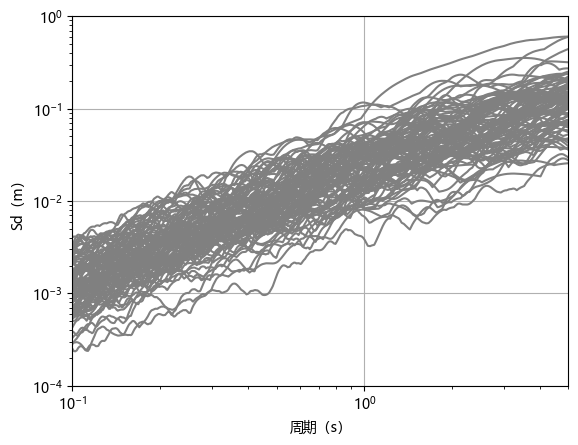

In [6]:
# Sd
import pandas as pd
from StochasticGroundMotionModeling import StochasticGroundMotionModeling
if __name__ == '__main__':
    
    plt.figure()
    for i in range(100):
        acc0, dt = StochasticGroundMotionModeling(6.69, 20.3, 1223, 0)
        
        # acc0 = np.array(acc_0)
        # acc0 = acc0/100
        acc0 = acc0 * 9.8
        # dt = 0.02
        # dt = 0.01
        n = len(acc0)
        t0 = np.linspace(0.0,dt*(n-1),n)
        ag = acc0
        dnt=0.01
        # zetas = [0.01,0.02,0.03,0.04,0.05,0.1]
        zetas = [0.05]
        
        num = 5000
        row = len(zetas)
        umax = np.zeros((row,num))
        vmax = np.zeros((row,num))
        amax = np.zeros((row,num))
        T = np.linspace(0.01,6.00,num)  #支持更高精度
        j=0
        for zeta in zetas: 
            i = 0
            for T1 in T:
                omg = 2.0*np.pi/T1
                umax[j][i], vmax[j][i], amax[j][i] = solve_nigam_jennings(omg, zeta, ag, dnt) #此处的dnt应该是迭代步长
                i = i+1
            j += 1 
        for js in range(j):
            plt.loglog(T,umax[js,:],label = r"damp=%s" % zetas[js], color = 'gray')
        
    plt.xlabel(r"周期（s）",fontsize=10)
    plt.ylabel(r"Sd（m）",fontsize=10)
    plt.grid(True)
    plt.xlim(0.1,5)
    plt.ylim(1e-4, 1)